## Modelo 1 DNN

### DNN

In [ ]:
### Muestra 1

In [4]:
import pandas as pd

# Cargar el archivo de datos 
df = pd.read_csv("../dataset/data/sample_4M_cod.csv")

# Verificar si la columna 'AttackCod' existe en el DataFrame
if 'AttackCod' not in df.columns:
    print("La columna 'AttackCod' no existe en el DataFrame.")
else:
    # Muestreo de filas de la clase 'Benign' (0) y 'DDoS' (1)
    benign_samples = df[df['AttackCod'] == 0].sample(n=90998, random_state=42, replace=True)
    ddos_samples = df[df['AttackCod'] == 1].sample(n=90998, random_state=42, replace=True)

    # Combinar las muestras en un solo DataFrame
    sampled_df = pd.concat([benign_samples, ddos_samples])

    # Imprimir las muestras
    print(sampled_df)

    # Guardar el DataFrame muestreado en un nuevo archivo CSV
    sampled_df.to_csv('../dataset/data/sample_comparacion.csv', index=False)

         L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  IN_PKTS  \
121958         39764         5963         6         0        44        1   
671155         49859          443         6        91      4326       28   
131932         45477         2196         6         0        44        1   
1414414        55350           53        17         5        74        1   
259178         52832           53        17         0        82        1   
...              ...          ...       ...       ...       ...      ...   
2934224        32862          443         6        91       164        3   
3208909        48650           80        17       188        56        2   
3474994         4636           80        17       188        84        3   
3965577        46520           80        17       188        56        2   
2476407        60771           80        17       188        84        3   

         OUT_BYTES  OUT_PKTS  TCP_FLAGS  CLIENT_TCP_FLAGS  ...  \
121958           0   

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping

#df= pd.read_csv("../dataset/data/sample_4M_cod.csv", dtype='int64')
df= pd.read_csv("../dataset/data/sample_comparacion.csv", dtype='int64')

In [2]:
import warnings
import tensorflow as tf

# Filtrar las advertencias de TensorFlow deprecated
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [7]:
y = df.AttackCod

In [6]:
#Grupos de caracteristicas
NIDS_features=['L4_DST_PORT', 'L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS',
                'CLIENT_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','DURATION_OUT','MIN_TTL',
                'MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN',
               'SRC_TO_DST_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT',
               'NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT']

X = df[NIDS_features]

# Escalamos solo las características (X) y no las etiquetas (y)
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)

# Tomamos las caracteristicas escaladas y las convertimso nuevamente a un dataframe
X = pd.DataFrame(X_sc, columns=NIDS_features)

X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181996 entries, 0 to 181995
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   L4_DST_PORT                 181996 non-null  float64
 1   L7_PROTO                    181996 non-null  float64
 2   IN_BYTES                    181996 non-null  float64
 3   IN_PKTS                     181996 non-null  float64
 4   OUT_BYTES                   181996 non-null  float64
 5   OUT_PKTS                    181996 non-null  float64
 6   CLIENT_TCP_FLAGS            181996 non-null  float64
 7   FLOW_DURATION_MILLISECONDS  181996 non-null  float64
 8   DURATION_IN                 181996 non-null  float64
 9   DURATION_OUT                181996 non-null  float64
 10  MIN_TTL                     181996 non-null  float64
 11  MAX_TTL                     181996 non-null  float64
 12  LONGEST_FLOW_PKT            181996 non-null  float64
 13  SHORTEST_FLOW_

,L4_DST_PORT,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,CLIENT_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,...,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT
0,0.090992,0.000000,0.000001,0.000000,0.000000e+00,0.000000,0.008969,0.0,0.0,0.0,...,0.001564,0.011034,0.000000,0.001564,0.522612,0.000093,0.000000,0.000006,0.015625,0.000000
1,0.006760,0.371429,0.000129,0.000233,1.543938e-04,0.000538,0.982063,0.0,0.0,0.0,...,0.140930,0.008276,0.083507,0.140930,0.522613,0.009159,0.034592,0.000254,0.125002,0.652781
2,0.033510,0.000000,0.000001,0.000000,3.349470e-07,0.000013,0.008969,0.0,0.0,0.0,...,0.001564,0.008276,0.083507,0.001564,0.522612,0.000093,0.000075,0.000011,0.015625,0.000000
3,0.000809,0.020408,0.000002,0.000000,9.964675e-07,0.000013,0.000000,0.0,0.0,0.0,...,0.008894,0.031724,0.154489,0.008894,0.522612,0.000157,0.000223,0.000011,0.000000,0.000000
4,0.000809,0.000000,0.000002,0.000000,9.545991e-07,0.000013,0.000000,0.0,0.0,0.0,...,0.008405,0.037241,0.171190,0.008405,0.522612,0.000174,0.000214,0.000011,0.000000,0.000000


In [4]:
# `X` son las características y `y` las clases (tipos de ataques)
# Se dividen los datos en entrenamiento (70%) y temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Se divide el conjunto temporal en validación y prueba (ambos 15% del total original)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(X_train.shape,X_test.shape)

(2800000, 22) (600000, 22)


In [9]:
from sklearn.model_selection import train_test_split
# X es tu conjunto de características y y es tu conjunto de etiquetas
# Dividir los datos en dos conjuntos con proporciones 61.5% y 38.5%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3846, random_state=42)
print(X_train.shape,X_test.shape)

(112000, 22) (69996, 22)


In [14]:
model = keras.Sequential([
        
    # Una capa oculta densa con 128 neuronas y función de activación ReLU
    layers.Dense(128, activation='relu', input_shape=(22,)),
    
    # Otra capa oculta densa con 64 neuronas
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.1), 
    
    # Capa de salida para 2 clases, con función de activación sigmoid 
    layers.Dense(1, activation='sigmoid')
])
# Compilación del modelo. 'sparse_categorical_crossentropy'.
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Visualizar el modelo en forma de gráfico y guardarlo en un archivo
plot_model(model, to_file='modelDNN_rfe22C.png', show_shapes=True, show_layer_names=True)

# Resumen del modelo para visualizar la arquitectura
model.summary()

# Definir el callback EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

start_time = time.time()
# Entrenamiento del modelo
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30,batch_size=128, callbacks=[early_stopping])
history = model.fit(X_train, y_train, epochs=30,batch_size=128, callbacks=[early_stopping])


# Calcular el tiempo transcurrido en minutos
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print("Tiempo de entrenamiento (minutos):", elapsed_time_minutes)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               2944      
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11,265
Trainable params: 11,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
875/875 [==============================] - 3s 3ms/step - loss: 0.0810 - accuracy: 0.9787
Epoch 2/30
875/875 [==============================] - 2s 2ms/step - loss: 0.0366 -

In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Realiza predicciones en los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convierte las probabilidades en clases predichas (usando un umbral de 0.5)

# Calcula la precisión, el recall y el F1-score para la clasificación binaria
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
f1 = f1_score(y_test, y_pred_classes, average='binary')
accuracy = accuracy_score(y_test, y_pred_classes)

print("Exactitud:", accuracy)
print("Sensibilidad:", recall)
print("Precisión:", precision)
print("F1-score:", f1)

2188/2188 [==============================] - 2s 967us/step
Exactitud: 0.9978570204011658
Sensibilidad: 0.9970987285604573
Precisión: 0.9986325955046578
F1-score: 0.997865072587532


### Guardar modelo keras

In [7]:
model.save('models_keras/dnn_rfe_2do.keras')

In [8]:
import pickle
# Guardar el historial de entrenamiento en un archivo(diccionario)
with open('models_keras/historydnn_rfe_2do.pkl', 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

##### cargar

In [55]:
from keras.models import load_model
# Cargar el modelo desde un archivo en formato nativo de Keras
model = load_model('models_keras/dnn_.keras')

In [56]:
import pickle
# Cargar el historial de entrenamiento desde un archivo
with open('models_keras/historydnn_.pkl', 'rb') as file:
   history = pickle.load(file)

### Exactitud y AUC

In [13]:
# Evaluación del modelo 
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Exactitud en el conjunto de prueba: {accuracy*100:.2f}%")

18750/18750 [==============================] - 15s 770us/step - loss: 0.0072 - accuracy: 0.9981
Exactitud en el conjunto de prueba: 99.81%


In [19]:
from sklearn.metrics import roc_curve, roc_auc_score,auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred)

In [ ]:


# Gráfica de la curva ROC
plt.figure(figsize=(15, 15))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

#auc_crv = auc(fpr, tpr)
print(f"El Area bajo la curva(AUC) es: {auc}")

# Mostrar la gráfica de la curva ROC
plt.show()

In [ ]:
# Gráfica del AUC
plt.figure(figsize=(5,5))
plt.bar(['AUC'], [auc], color='b', alpha=0.7)
plt.ylim([0.0, 1.0])
plt.ylabel('AUC Score')
plt.title('Área bajo la Curva (AUC)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Mostrar la gráfica del AUC
plt.show()

### Mejores

In [13]:
# Evaluar el modelo en los conjuntos de datos
train_metrics = model.evaluate(X_train, y_train, verbose=0)
val_metrics = model.evaluate(X_val, y_val, verbose=0)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

# Imprimir las métricas
metric_names = ['loss', 'accuracy', 'recall', 'precision', 'f1']
print("Metricas Datos Entrenamiento:")
for name, val in zip(metric_names, train_metrics):
    print(f"{name}: {val}")

print("\nMetricas Datos Validación:")
for name, val in zip(metric_names, val_metrics):
    print(f"{name}: {val}")

print("\nMetricas datos de prueba:")
for name, val in zip(metric_names, test_metrics):
    print(f"{name}: {val}")

Metricas Datos Entrenamiento:
loss: 0.002996098017320037
accuracy: 0.999021053314209

Metricas Datos Validación:
loss: 0.0035065971314907074
accuracy: 0.9990466833114624

Metricas datos de prueba:
loss: 0.0032107182778418064
accuracy: 0.9990116953849792


### Graficar Curvas Aprendizaje Modelo en memoria (no cargado)

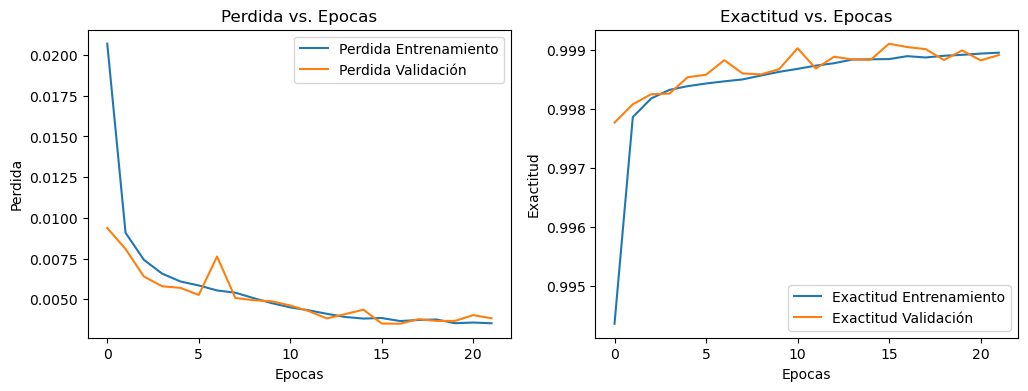

In [9]:
# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()


### Cargar diccionario de historia con pickle y graficar curvas de aprendizaje

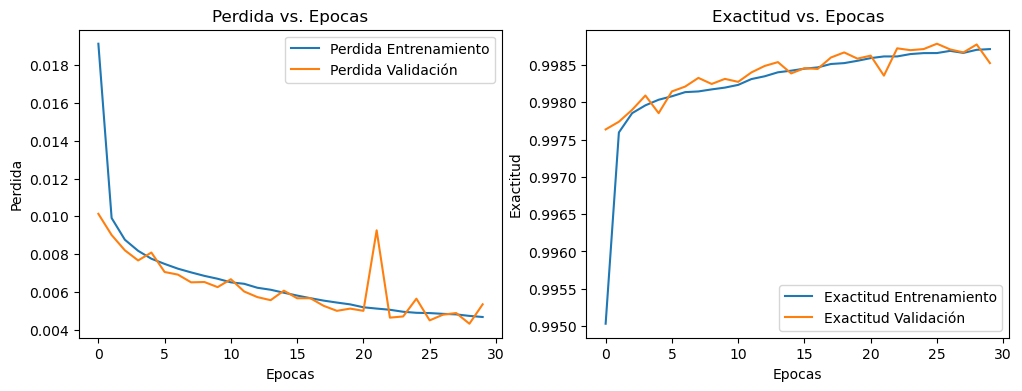

In [57]:

# Gráfico de la pérdida y la precisión en el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Perdida Entrenamiento')
plt.plot(history['val_loss'], label='Perdida Validación')
plt.title('Perdida vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Perdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Exactitud Entrenamiento')
plt.plot(history['val_accuracy'], label='Exactitud Validación')
plt.title('Exactitud vs. Epocas')
plt.xlabel('Epocas')
plt.ylabel('Exactitud')
plt.legend()

plt.show()


### Matriz de confusión

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Hacer predicciones
predicciones = model.predict(X_test)  # X_val es el conjunto de validación/prueba

# En un problema de clasificación binaria, normalmente se redondea la probabilidad a 0 o 1
# Esto es asumiendo que el modelo produce una salida de probabilidad para la clase positiva
predicciones_etiquetas = (predicciones > 0.5).astype(int)

# Generar la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones_etiquetas)

# Imprimir la matriz de confusión
print(matriz_confusion)

18750/18750 [==============================] - 19s 1ms/step
[[299785    215]
 [   378 299622]]


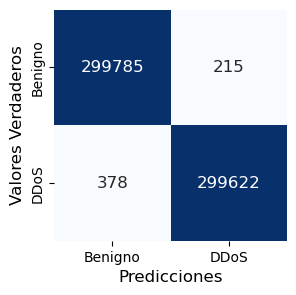

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'matriz_confusion' es tu matriz de confusión calculada previamente

# Definir los nombres de las clases
class_names = ["Benigno", "DDoS"]

# Crear un mapa de calor con Seaborn
plt.figure(figsize=(3, 3))  # Ajustar el tamaño del gráfico
sns.heatmap(matriz_confusion, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})  # Ajustar el tamaño de la fuente

# Añadir etiquetas y título para mayor claridad
plt.xlabel('Predicciones', fontsize=12)  # Ajustar el tamaño de la fuente
plt.ylabel('Valores Verdaderos', fontsize=12)  # Ajustar el tamaño de la fuente
#plt.title('Matriz de Confusión', fontsize=12)  # Ajustar el tamaño de la fuente
plt.show()
